In [1]:
# Required for all calculations
import numpy as np
import mhs

# For timing our results
from time import time
timings = {}

# Required for scattered node layout
from scipy import interpolate, ndimage
from rbf.pde import fd

# Required to pull SHARP from jsoc
import os
from astropy.io import fits
import drms

# Required to visualize results
%matplotlib ipympl
import matplotlib.pyplot as plt

In [2]:
# First pull a SHARP image

series = 'hmi.sharp_cea_720s'
sharpnum = 7821
year=2021
month=11
day = 9
hour = 3
minute = 24
second = 0
timings['sharpStart'] = time()

tstr = '{ye}.{mo:02d}.{da:02d}_{ho:02d}:{mi:02d}:{se:02d}'.format(
        ye=year,mo=month,da=day,ho=hour,mi=minute,se=second
        )

c = drms.Client(email = 'nathanielhm@gmail.com', verbose=False)
tempdir = '.\\sharpdata'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)

exp_query = '{series}[{sharpnum}][{year}.{month:02d}.{day:02d}_{hour:02d}:{minute:02d}:{second:02d}]'
fname = f'{series}.{sharpnum}.{year}{month:02d}{day:02d}_{hour:02d}{minute:02d}{second:02d}_TAI.' + '{segment}.fits'

metadata = c.query(exp_query.format(
                      series=series,sharpnum=sharpnum,
                      year=year,month=month,day=day,hour=hour,minute=minute,second=second
                  ), key=['RSUN_REF','RSUN_OBS','CDELT1','CDELT2'])
if not (os.path.exists(tempdir + '\\' + fname.format(segment='Bt')) and \
        os.path.exists(tempdir + '\\' + fname.format(segment='Br')) and \
        os.path.exists(tempdir + '\\' + fname.format(segment='Bp'))):
    request = c.export(exp_query.format(
                          series=series,sharpnum=sharpnum,
                          year=year,month=month,day=day,hour=hour,minute=minute,second=second
                      ) + '{Bt,Br,Bp}')
    request.download(tempdir)

sharpfitsT = fits.open(tempdir + '\\' + fname.format(segment='Bt'),memmap = False)
sharpfitsR = fits.open(tempdir + '\\' + fname.format(segment='Br'),memmap = False)
sharpfitsP = fits.open(tempdir + '\\' + fname.format(segment='Bp'),memmap = False)

Bt = sharpfitsT[1].data.transpose()
Br = sharpfitsR[1].data.transpose()
Bp = sharpfitsP[1].data.transpose()

lenX = metadata.iloc[0].RSUN_REF / metadata.iloc[0].RSUN_OBS * metadata.iloc[0].CDELT1 * sharpfitsT[1].header['NAXIS1'] / 1e6
lenY = metadata.iloc[0].RSUN_REF / metadata.iloc[0].RSUN_OBS * metadata.iloc[0].CDELT2 * sharpfitsT[1].header['NAXIS2'] / 1e6
lenZ = np.max((lenX,lenY))*2

timings['sharpEnd'] = time()
print(f"SHARP pull and read completed in  {timings['sharpEnd']-timings['sharpStart']:.02f} seconds")

SHARP pull and read completed in  2.53 seconds


In [3]:
# Create a new, adaptively scattered domain in cartesian geometry
timings['nodeStart'] = time()

points = (np.linspace(0,lenX,sharpfitsR[1].header['NAXIS1']),np.linspace(0,lenY,sharpfitsR[1].header['NAXIS2']))
BxInterp = interpolate.RegularGridInterpolator(points,Bt)
BzInterp = interpolate.RegularGridInterpolator(points,Br)
ByInterp = interpolate.RegularGridInterpolator(points,-Bp)

supersmooth = ndimage.maximum_filter(abs(ndimage.gaussian_laplace(Br,1)),20)
smoothfn = interpolate.RegularGridInterpolator(points,(1-supersmooth/np.max(supersmooth.ravel())))

def rfn(xyz):
    if len(xyz.shape) == 1:
        xyz = np.expand_dims(xyz,0)
    omega = 1 / lenZ;
    return smoothfn((xyz[:,0],xyz[:,1])) ** 2 * lenZ/2 * 2e-2 + lenZ/2*8e-3 * np.exp(omega*xyz[:,2]);

nodes = mhs.node_drop_3d([0,lenX,0,lenY,0,lenZ], Bt.shape, 1e5, rfn)
n = nodes.shape[0]
index = mhs.Index(np.where(nodes[:,0]<1e-4*lenX)[0],np.where((np.max(nodes[:,0])-nodes[:,0])<1e-4*lenX)[0],
                  np.where(nodes[:,1]<1e-4*lenY)[0],np.where((np.max(nodes[:,1])-nodes[:,1])<1e-4*lenY)[0],
                  np.where(nodes[:,2]<1e-4*lenZ)[0],np.where((np.max(nodes[:,2])-nodes[:,2])<1e-2*lenZ)[0],[]
                 )
timings['nodeBuilt'] = time()
print(f"Built nodes (n={nodes.shape[0]:.02f},zmax={max(nodes[:,2])}) in {timings['nodeBuilt']-timings['nodeStart']:.02f} seconds")
print('Determined boundary nodes with counts: ' + str(index))

Bx0 = np.expand_dims(BxInterp((nodes[index.z0,0],nodes[index.z0,1])),1)
By0 = np.expand_dims(ByInterp((nodes[index.z0,0],nodes[index.z0,1])),1)
Bz0 = np.expand_dims(BzInterp((nodes[index.z0,0],nodes[index.z0,1])),1)

# And now we can create the differentiation matrices for this domain
stencil_n = 70
order = 2
Dx  = fd.weight_matrix(nodes,nodes,stencil_n,[1,0,0],phi='phs5',order=order).tocsr()
timings['nodeDx'] = time()
print(f"Computed Dx in {timings['nodeDx']-timings['nodeBuilt']:.02f} seconds.")
Dy  = fd.weight_matrix(nodes,nodes,stencil_n,[0,1,0],phi='phs5',order=order).tocsr()
timings['nodeDy'] = time()
print(f"Computed Dy in {timings['nodeDy']-timings['nodeDx']:.02f} seconds.")
Dz  = fd.weight_matrix(nodes,nodes,stencil_n,[0,0,1],phi='phs5',order=order).tocsr()
timings['nodeDz'] = time()
print(f"Computed Dz in {timings['nodeDz']-timings['nodeDy']:.02f} seconds.")
Dxx = fd.weight_matrix(nodes,nodes,stencil_n,[2,0,0],phi='phs5',order=order).tocsr()
timings['nodeDxx'] = time()
print(f"Computed Dxx in {timings['nodeDxx']-timings['nodeDz']:.02f} seconds.")
Dyy = fd.weight_matrix(nodes,nodes,stencil_n,[0,2,0],phi='phs5',order=order).tocsr()
timings['nodeDyy'] = time()
print(f"Computed Dyy in {timings['nodeDyy']-timings['nodeDxx']:.02f} seconds.")
Dzz = fd.weight_matrix(nodes,nodes,stencil_n,[0,0,2],phi='phs5',order=order).tocsr()
timings['nodeDzz'] = time()
print(f"Computed Dzz in {timings['nodeDzz']-timings['nodeDyy']:.02f} seconds.")

Built nodes (n=88124.00,zmax=36.64456770653862) in 157.41 seconds
Determined boundary nodes with counts: x0:797, x1:744, y0:2053, y1:1769, z0:871, z1:290
Computed Dx in 71.03 seconds.
Computed Dy in 68.44 seconds.
Computed Dz in 66.02 seconds.
Computed Dxx in 68.93 seconds.
Computed Dyy in 68.77 seconds.
Computed Dzz in 66.89 seconds.


In [ ]:
# Now we are ready to perform the MHS extrapolation
importlib.reload(mhs)
timings['mhsInit'] = time()
config = {'lsqr_tol':1e-5,
          'lsqr_iter':1e4,
          'maxiters':2,
          'gpu':False,
          'verbose':True
         }
# First compute the potential field
Bpot = mhs.potfield(nodes, Bz0, Dx, Dy, Dz, Dxx, Dyy, Dzz, index,
                    config=config)
timings['Bpot'] = time()
print(f"Computed potential field in {timings['Bpot']-timings['mhsInit']} seconds.")
B, r = mhs.num_mhs(np.zeros((n,1)),np.zeros((n,1)), Bx0,By0,Bz0, nodes, Dx, Dy, Dz, Dxx, Dyy, Dzz, index,
                   config=config, Binit=Bpot)
timings['Bmhs'] = time()
print(f"Computed mhs field in {timings['Bmhs']-timings['Bpot']} seconds.")

Potential solution done: 1. Iteration 2087 returned residual 918.4352032264244
Computed potential field in 148.50222373008728 seconds.
Starting iterations -- initial residual 4.315096e+06
building J


C:\Users\nhmathew\AppData\Local\anaconda3\envs\solar\Lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


cuthill...
J built. Starting lsqr


In [ ]:
fig = plt.figure()
ax = plt.subplot(2,1,1)
ax = ax.scatter(nodes[index.z0,0],nodes[index.z0,1],c=Bpot[index.z0,2],s=10)
plt.colorbar(ax)
ax = plt.subplot(2,1,2)
ax = ax.scatter(nodes[index.z0,0],nodes[index.z0,1],c=Bz0,s=10)
plt.colorbar(ax)
plt.show()

In [5]:
import importlib
importlib.reload(mhs)

<module 'mhs' from 'C:\\Users\\nhmathew\\Documents\\code\\python\\mhs.py'>

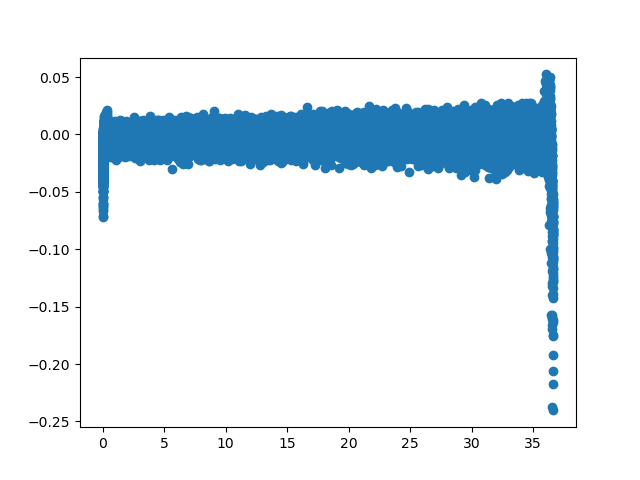

In [136]:
fig = plt.figure()
ax = plt.scatter(nodes[:,2],Dz.dot(nodes[:,2]**3)-3*nodes[:,2]**2)
plt.show()

In [157]:
cupyx.scipy.sparse.linalg.lsqr()

TypeError: lsqr() missing 2 required positional arguments: 'A' and 'b'

In [165]:
import inspect